In [1]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [2]:
# Set path to the current working directory
current_directory = os.getcwd()
data_path = os.path.join(current_directory, 'pointclouds-500')

# List all .xyz files in the directory
file_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.xyz')]

# looping over files list to extract xyz values
point_cloud = []
for file in file_paths:
    df = pd.read_csv(file, delimiter=" ", names=['x', 'y', 'z'])
    x_values = df['x'].values
    y_values = df['y'].values
    z_values = df['z'].values
    point_cloud.append(np.column_stack((x_values, y_values, z_values)))

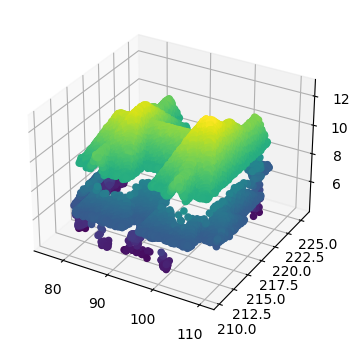

In [3]:
# visualise elements individually in 3D space (optional)
# 000 - 099: building
# 100 - 199: car
# 200 - 299: fence
# 300 - 399: pole
# 400 - 499: tree
t = int(input("Object visualization query: "))  # the item no. for 3D viz
x_data = point_cloud[t][:, 0]
y_data = point_cloud[t][:, 1]
z_data = point_cloud[t][:, 2]

# plot the query
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, c=z_data, alpha=1)
plt.show()


In [28]:
# class to extract features
class Features:
    def __init__(self, objects):
        self.objects = objects
        self.initialize()
    
    # feature 1: max height
    def max_height(self, z):
        max_h = max(z)
        return max_h

    # feature 2: ground area covered
    def ground_area(self, x, y):
        ground_a = (max(x) - min(x)) * (max(y) - min(y))
        return ground_a
    
    # feature 3: density
    def density(self, x, y, z, n_points):
        volume = ((max(x) - min(x)) * (max(y) - min(y)) * (max(z) - min(z)))
        density = volume/n_points
        return density
    
    # feature 4: projected bounding box
    def get_areas(self, X, Y):
        X_rounded = [round(x) for x in X]
        Y_rounded = [round(y) for y in Y]
        x_max, x_min, y_max, y_min = max(X_rounded), min(X_rounded), max(Y_rounded), min(Y_rounded)
        x_max, x_min = x_max + 0.5, x_min - 0.5
        y_max, y_min = y_max + 0.5, y_min - 0.5
        bb_len, bb_width = abs(x_max - x_min), abs(y_max - y_min)
        bb_area = bb_len * bb_width
        string_repr = [','.join([str(x), str(y)]) for x, y in zip(X_rounded, Y_rounded)]
        projected_area = len(set(string_repr))
        ratio_bb = projected_area/bb_area * 100
        return ratio_bb
    
    # feature 5: mean height
    def average_height(self, z):
        avg_h = np.mean(z)
        return avg_h

    # feature 6: planarity
    # Eigenvalues: when multiplied to a given vector, result in a scaled version of that vector
    # ratio of the smallest eigenvalue to the sum of all three eigenvalues
    # Planarity varies between 0 and 1,
    # where 0 indicates that all the eigenvalues are equal,
    # meaning that the surface is entirely planar,
    # and 1 indicates that one eigenvalue is significantly smaller than the other two,
    # indicating a significant variation in the surface.
    # https://nl.mathworks.com/help/matlab/ref/eig.html
    def planarity(self, x, y, z):
        cov = np.cov(np.array([x, y, z]))
        eigenval, eigenvect = np.linalg.eig(cov)
        eigenval.sort()
        planarity = ((eigenval[1] + eigenval[0]) / (eigenval[0] + eigenval[1] + eigenval[2]))
        return planarity

    def extract_xyz(self, cloud):
        x = []
        y = []
        z = []
             
        for point in cloud:
            # Extract the x, y, z values from the object
            
            x.append(point[0])
            y.append(point[1])
            z.append(point[2])
         
        n_points = len(x)
        return x, y, z, n_points
        
    def calc_all_features(self):
        df = pd.DataFrame({
            'max_heights': [],
            'ground_area': [],
            'density': [],
            'projected_bb': [],
            'average_height': [],
            'planarity': []
        })

        for item in self.objects:
            x, y, z, n_points = self.extract_xyz(item)
            data = {
                'max_heights': self.max_height(z),
                'ground_area': self.ground_area(x, y),
                'density': self.density(x, y, z, n_points),
                'projected_bb': self.get_areas(x, y),
                'average_height': self.average_height(z),
                'planarity': self.planarity(x, y, z)
            }
            data = pd.DataFrame([data])
            df = pd.concat([df, data], ignore_index=True)

        return df
    
    def initialize(self):
        df = self.calc_all_features()
        df['label'] = ''
        df['label'][0:99] = 'building'
        df['label'][100:199] = 'car'
        df['label'][200:299] = 'fence'
        df['label'][300:399] = 'pole'
        df['label'][400:499] = 'tree'
        self.df = df
        return 
        

In [29]:
features = Features(point_cloud)
display(features.df)
df_features = features.df

C:\Users\Dell\AppData\Local\Temp\ipykernel_27512\2172962241.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][0:99] = 'building'
C:\Users\Dell\AppData\Local\Temp\ipykernel_27512\2172962241.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][100:199] = 'car'
C:\Users\Dell\AppData\Local\Temp\ipykernel_27512\2172962241.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][200:299] = 'fence'
C:\Use

,max_heights,ground_area,density,projected_bb,average_height,planarity,label
0,19.730000,48.731934,0.135232,91.666667,18.003383,0.199947,building
1,8.470000,64.715485,0.112223,78.571429,7.385178,0.308227,building
2,15.570000,273.662312,0.228969,83.006536,12.986387,0.419449,building
3,16.469999,354.430061,0.243781,72.474747,13.856272,0.397191,building
4,9.750000,520.882345,0.223818,61.739130,7.823214,0.364260,building
...,...,...,...,...,...,...,...
495,11.540000,40.565323,0.106486,75.000000,7.438339,0.580601,tree
496,15.170000,106.506569,0.198018,71.969697,9.659321,0.561576,tree
497,11.110000,36.537662,0.213788,77.083333,7.443952,0.389778,tree
498,18.910000,40.327366,0.228704,80.000000,12.962448,0.455015,tree


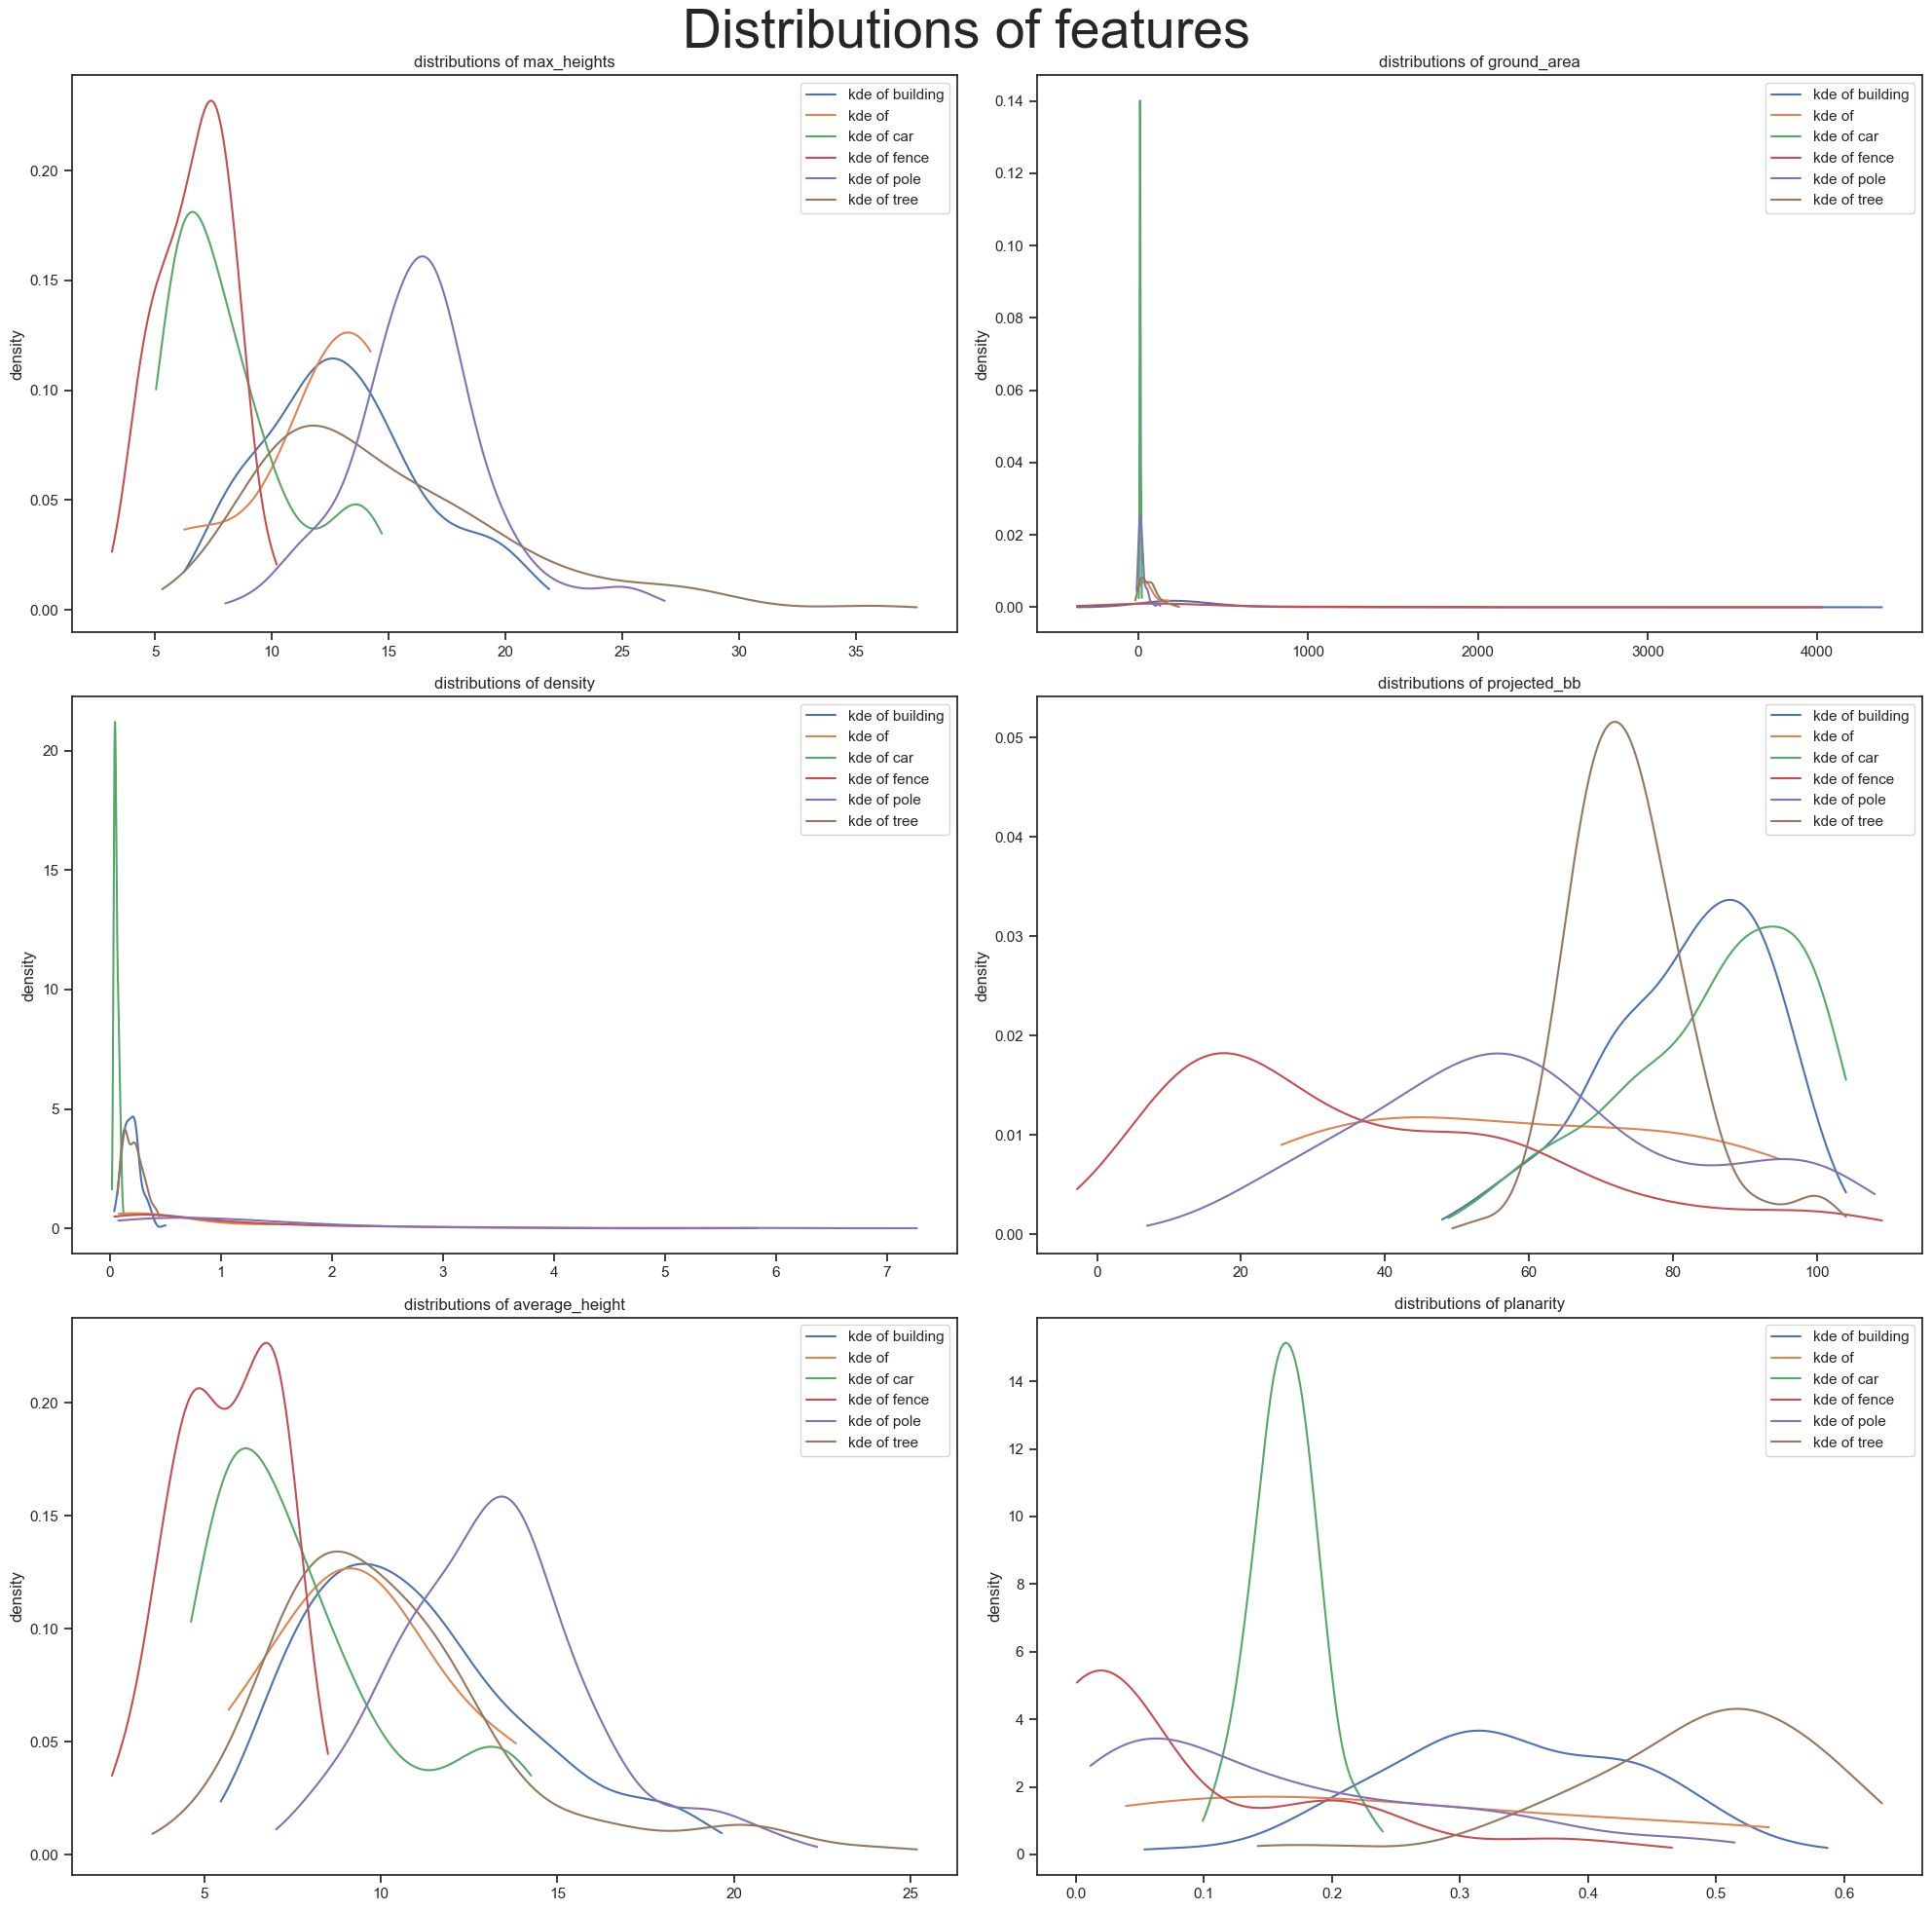

In [35]:
# looking at the distribution of the features
def distributions(dataframe):

    fig, axs = plt.subplots(int((dataframe.shape[1]-1)/2), 2, figsize=(20, 20))
    class_names = dataframe['label'].unique()
    for i, ax in enumerate(axs.flatten()):
        feature_names = dataframe.columns.unique()
        data_name = feature_names[i]
        for class_name in class_names:
            data = dataframe[dataframe['label'] == class_name][data_name]
            
            mean, std_dev = np.mean(data), np.std(data)
            range = max(data) - min(data)
            
            x = np.linspace(min(data)-int(range/10), max(data)+int(range/10), 1000)
            pdf = norm.pdf(x, loc=mean, scale=std_dev)
            kde = gaussian_kde(data)
            # ax.plot(x, pdf, label=f'pdf of {class_name}')
            ax.plot(x, kde(x), label=f'kde of {class_name}')
            # ax.hist(data, bins=20, density=True, label=f'histogram of {class_name}')
        ax.set_title(f'distributions of {data_name}')
        ax.legend()
        ax.set_ylabel(f'density')
        
    plt.tight_layout()
    plt.suptitle('Distributions of features', fontsize=40)
    plt.show()

distributions(df_features)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


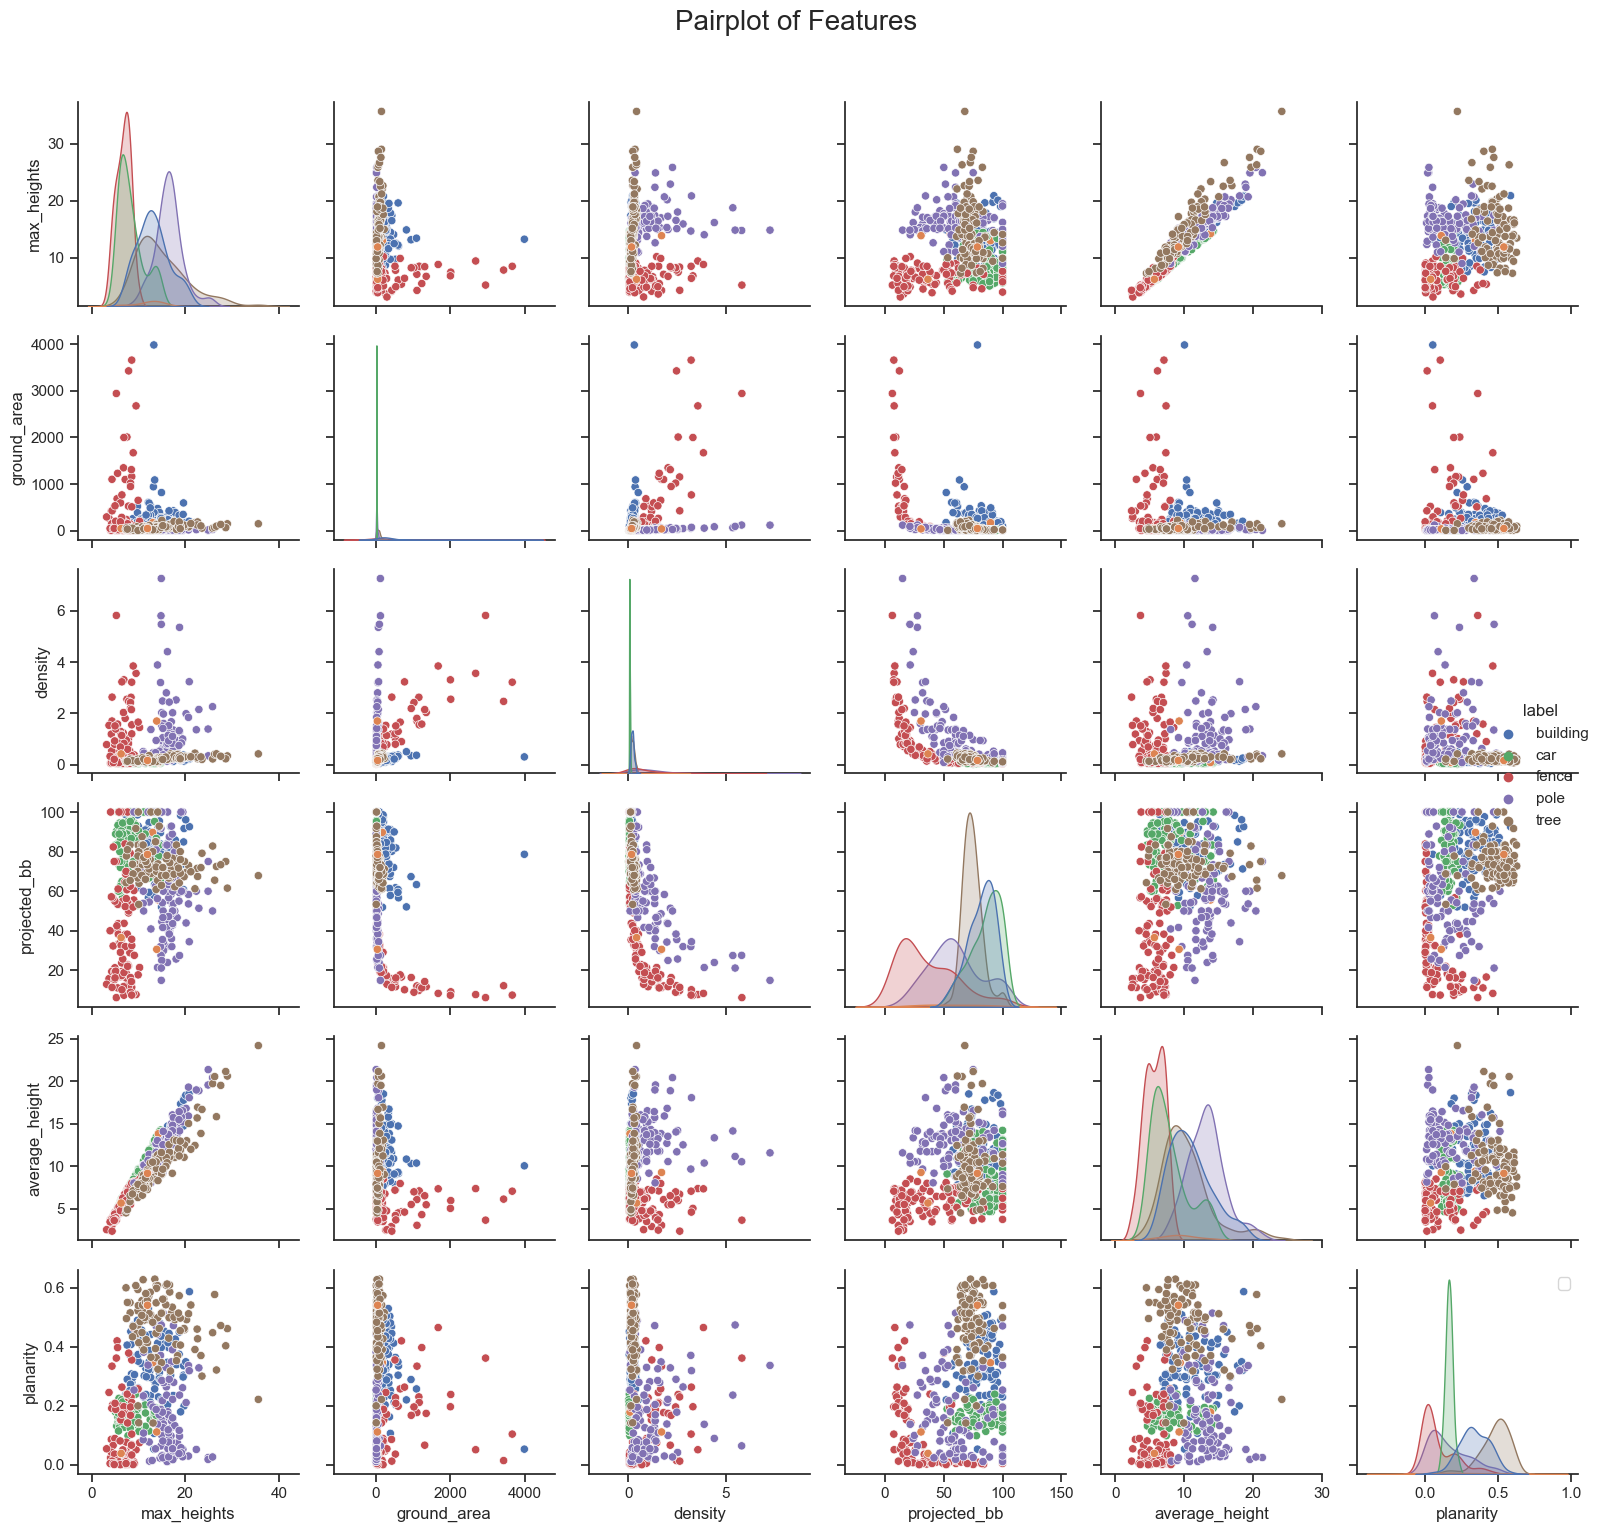

In [41]:
def pairplot_features(dataframe):
    sns.set(style="ticks")
    g = sns.pairplot(dataframe, hue='label')
    plt.suptitle("Pairplot of Features", y=1.02, fontsize=20)
    plt.legend(loc='upper right')
    plt.show()

pairplot_features(features.df)

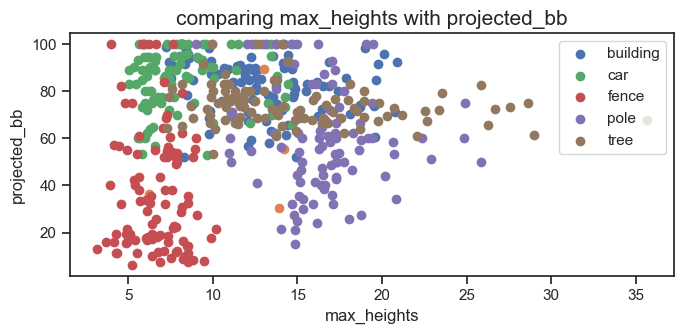

In [40]:
# further inspecting the comparison distribution of two features
def pointclouds(dataframe, data_1, data_2):
    for class_ in dataframe['label'].unique():
        
        plt.scatter(dataframe[dataframe['label'] == class_][data_1], dataframe[dataframe['label'] == class_][data_2], label=class_)
        plt.xlabel(f'{data_1}')
        plt.ylabel(f'{data_2}')
        plt.title(f'comparing {data_1} with {data_2}', size=15)
        plt.legend(loc='upper right')
    return

pointclouds(features.df, 'max_heights', 'projected_bb')

In [8]:
# separate the df_features (X) and labels (y) to train and test the model
X = df_features.drop('label', axis=1)
y = df_features['label']


In [9]:
# SVM classifier
def SVM_classifier(x_data, y_data, test_size, kernel, C=1, max_iter=-1, decision_func_shape='ovr', random_state=42):
    """
    Train and evaluate a Support Vector Machine (SVM) classifier.

    Args:
    - x_data (DataFrame): Input features.
    - y_data (Series): Target labels.
    - test_size (float): Proportion of the dataset to include in the test split.
    - kernel (str): Specifies the kernel type to be used in the algorithm.
    - C (float, optional): Regularization parameter. Defaults to 1.
    - max_iter (int, optional): Hard limit on iterations within solver. Defaults to -1.
    - decision_func_shape (str, optional): Shape of decision function. Defaults to 'ovr'.
    - random_state (int, optional): Random seed. Defaults to 42.

    Returns:
    - accuracy (float): Accuracy of the classifier.
    - mean_class_acc (float): Mean per class accuracy of the classifier.
    """
    #split train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)

    # Scale input data
    scale_features = StandardScaler()
    X_train = scale_features.fit_transform(X_train)
    X_test = scale_features.transform(X_test)

    # train SVM model
    classifier = svm.SVC(C=C, kernel=kernel, gamma='scale', max_iter=max_iter, decision_function_shape=decision_func_shape, random_state=random_state)
    classifier.fit(X_train, y_train)

    # Predict using trained model
    y_hat = classifier.predict(X_test)

    # evaluate classifier
    accuracy = accuracy_score(y_test, y_hat)
    class_acc = classification_report(y_test, y_hat, digits=3, zero_division=1, output_dict=True)

    # compute mean per class accuracy
    mean_class_acc = np.mean([class_acc[str(cls)]['recall'] for cls in class_acc.keys() if cls.isdigit()])

    return accuracy, mean_class_acc

In [10]:
def SVM_classifier(x_data, y_data, test_size,kernel, C=1, max_iter=-1, decision_func_shape='ovr', feat_importance=False, svm_metrics=False, confusion_mat=False, random_state=42):
    
    # Split train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)
    
    # Scale input data
    scale_features = StandardScaler()
    X_train = scale_features.fit_transform(X_train)
    X_test = scale_features.transform(X_test)

    func = svm.SVC(C=C, kernel=kernel, gamma='scale', max_iter=max_iter, decision_function_shape=decision_func_shape, random_state=random_state)
    func.fit(X_train, y_train)

    

    # y_hat holds the predicted values of trained svm model
    y_hat = func.predict(X_test)
 
    # evaluate the accuracy of the classifier
    # accuracy = (TP + TN) / (TP + TN + FP + FN)  [predicted/ total]
    accuracy = func.score(X_test, y_test)
    
    # evaluate the mean per class accuracy
    class_names = y_test.unique()
    correct = 0 
    y_test_array = y_test.values
    for i in range(len(class_names)):
        correct_class = 0
        indexes = np.where(y_test_array == class_names[i])
        indexes = indexes[0]
        for index in indexes:          
            if y_hat[index] == class_names[i]:
                correct_class += 1
        acc_class = correct_class/len(indexes)
        correct += acc_class
        
    mean_class_acc = np.round(correct/len(class_names), 3)
   
        
    if feat_importance == True:

        # feature importance for svm
        feature_importance = permutation_importance(func, X_test, y_test)
        feature_names = np.array(x_data.columns.unique())
        sorted_idx = feature_importance.importances_mean.argsort()
        feat_svm = feature_names[sorted_idx]
        score_svm = feature_importance.importances_mean[sorted_idx]

        # Print feature names and their importance's in a sorted list
        print("Feature Importance of SVM:")
        for i in range(len(feat_svm)):
            print(f"{feat_svm[i]}: {round(score_svm[i],3)}")
        print()

    if svm_metrics == True:
        print('svm report: ')
        print(classification_report(y_test, y_hat, digits=3, zero_division=1))

    if confusion_mat ==True:
        # create confusion matrix with y_hat and y_test
        # confusion matrix compares values from y_hat with y_test using sklearn.metrics
        # confusion matrix shows True positive(TP), False positive(FP), True negative(TN), False negative(FN)
        # https://www.v7labs.com/blog/confusion-matrix-guide
        conf_matrix = confusion_matrix(y_pred=y_hat, y_true=y_test)
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        # Build the plot through heatmap
        plt.figure(figsize=(16, 7))
        sns.set(font_scale=1.4)
        
        sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 10},
                    cmap=plt.cm.Blues, linewidths=0.2, xticklabels=class_names, yticklabels=class_names)

        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix for SVM Model')
        plt.show()
    
    return accuracy, mean_class_acc

   


In [11]:
accuracy, mean_accuracy = SVM_classifier(X, y, 0.2, 'rbf', C=3)

In [12]:
C_list = [0.1, 0.25, 0.5, 1, 1.5, 2, 5, 10]
kernel_list = ['poly', 'rbf', 'sigmoid']
# class_weight = [{}]
max_iter = [-1, 100, 200, 500, 1000, 5000]
decisionfunctionshape = ['ovo', 'ovr']

accuracy_list = []
mean_accuracy_list = []
for c in C_list:
    for kernel in kernel_list:
        for max_i in max_iter:
            for dec_shape in decisionfunctionshape:
                accuracy, mean_accuracy = SVM_classifier(X, y, 0.2, kernel, C=c, max_iter=max_i, decision_func_shape=dec_shape)
                accuracy_list.append(accuracy)
                mean_accuracy_list.append(mean_accuracy)
                if accuracy >= max(accuracy_list):
                    accuracy_max = accuracy
                    best_C, best_kernel, best_max_i, best_dec_shape = c, kernel, max_i, dec_shape
                    
                if mean_accuracy >= max(mean_accuracy_list):
                    mean_accuracy_max = mean_accuracy
                    mbest_C, mbest_kernel, mbest_max_i, mbest_dec_shape = c, kernel, max_i, dec_shape

print(f'The best accuracy is {accuracy_max} with:\n C:{best_C}\n kernel:{best_kernel}\n maximum iterations:{best_max_i}\n decision function shape:{best_dec_shape}')
print(f'The best mean per class accuracy is {mean_accuracy_max} with: \n C:{best_C}\n kernel:{best_kernel}\n maximum iterations:{best_max_i}\n decision function shape:{best_dec_shape}')




C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation

The best accuracy is 0.98 with:
 C:10
 kernel:rbf
 maximum iterations:5000
 decision function shape:ovr
The best mean per class accuracy is 0.985 with: 
 C:10
 kernel:rbf
 maximum iterations:5000
 decision function shape:ovr


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation

In [13]:
def RF_classifier(x_data, y_data, test_size, n_estimators=100, criterion='gini', max_features='sqrt', bootstrap=True, max_samples=None,  feat_importance=False, rf_metrics=False, confusion_mat=False, random_state=42):
    # Split train and test data
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=random_state)
    
    rf_func = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_features=max_features, bootstrap=bootstrap, max_samples=max_samples, random_state=random_state, oob_score=False)
    rf_func.fit(X_train, y_train)
    
    # calculate the predictions on the test set
    y_hat_rf = rf_func.predict(X_test)

    # calculate the accuracy of the classifier
    # can also calculate F1 score if required
    # F1 = 2 * (precision * recall) / (precision + recall)
    # precision measures how many of the predicted positives are actually positive
    # recall measures how many of the actual positives are correctly identified by the model
    class_names = y_test.unique()
    
    
    accuracy = accuracy_score(y_test, y_hat_rf)

    correct = 0 
    y_test_array = y_test.values
    for i in range(len(class_names)):
        correct_class = 0
        indexes = np.where(y_test_array == class_names[i])
        indexes = indexes[0]
        for index in indexes:          
            if y_hat_rf[index] == class_names[i]:
                correct_class += 1
        acc_class = correct_class/len(indexes)
        correct += acc_class
        
    mean_class_acc = np.round(correct/len(class_names), 3)

    f1 = f1_score(y_true=y_test, y_pred=y_hat_rf, average='weighted')
    
    # print('F1 score: ', f1)
    
    
    if feat_importance == True:
        # feature importance for rf
        importance = rf_func.feature_importances_
        for i, v in enumerate(importance):
            print('Feature importance: %0d, Score: %.5f' % (i, v))

    if confusion_mat == True:
        # create confusion matrix
        conf_matrix = confusion_matrix(y_pred=y_hat_rf, y_true=y_test)
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        # Build the plot through heatmap
        plt.figure(figsize=(16, 7))
        sns.set(font_scale=1.4)
        sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 10},
                    cmap=plt.cm.Greens, linewidths=0.2, xticklabels=class_names, yticklabels=class_names)

        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion Matrix for Random Forest Model')
        plt.show()
    if rf_metrics == True:
        print('rf report: ')
        print(classification_report(y_test, y_hat_rf, digits=3, zero_division=1))

    return accuracy, mean_class_acc

In [14]:
# accuracy = RF_classifier(X, y, 0.2)


In [15]:
n_estimators = [10, 25, 50, 100, 200, 500, 1000]
criterion = ['gini', 'entropy', 'log_loss']
max_features = ['sqrt', 'log2', None]
bootstrap = [True, False]
max_samples = []

rf_accuracy_list = []
rf_mean_accuracy_list = []
for n_est in n_estimators:
    for crit in criterion:
        for max_f in max_features:
            for bootstr in bootstrap:         
                accuracy, mean_accuracy = RF_classifier(X, y, 0.2, n_estimators=n_est, criterion=crit, max_features=max_f, bootstrap=bootstr)
                rf_accuracy_list.append(accuracy)
                rf_mean_accuracy_list.append(mean_accuracy)
                if accuracy >= max(rf_accuracy_list):
                    rf_accuracy_max = accuracy
                    max_n_est, max_crit, max_max_f, max_bootstr = n_est, crit, max_f, bootstr
                if mean_accuracy >= max(rf_mean_accuracy_list):
                    rf_mean_accuracy_max = mean_accuracy
                    mmax_n_est, mmax_crit, mmax_max_f, mmax_bootstr = n_est, crit, max_f, bootstr

print(f'The best accuracy is {rf_accuracy_max} with:\n number of estimators:{max_n_est}\n criterion:{max_crit}\n maximum features:{max_max_f}\n bootstrap:{max_bootstr}')
print(f'The best mean per class accuracy is {rf_mean_accuracy_max} with:\n number of estimators:{mmax_n_est}\n criterion:{mmax_crit}\n maximum features:{mmax_max_f}\n bootstrap:{mmax_bootstr}')

KeyboardInterrupt: 

In [ ]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
   rfc, X_train, y_train, cv=10, scoring='accuracy',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the train and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy score')
plt.legend(loc='best')
plt.show()

NameError: name 'rfc' is not defined

In [ ]:
# create confusion matrix
conf_matrix = confusion_matrix(y_pred=y_hat_rf, y_true=y_test)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Build the plot through heatmap
plt.figure(figsize=(16, 7))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 10},
            cmap=plt.cm.Greens, linewidths=0.2, xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# calculate the accuracy of the classifier
# can also calculate F1 score if required
# F1 = 2 * (precision * recall) / (precision + recall)
# precision measures how many of the predicted positives are actually positive
# recall measures how many of the actual positives are correctly identified by the model
accuracy = accuracy_score(y_test, y_hat_rf)
f1 = f1_score(y_true=y_test, y_pred=y_hat_rf, average='weighted')
print('Accuracy: ', accuracy)
print('F1 score: ', f1)
print('rf report: ')
print(classification_report(y_test, y_hat_rf, digits=3, zero_division=1))


In [ ]:
# Own function for learning curve visualization
# Requirements: • X axis: training set size (0-500)
# Y axis: classification error 
# Two curves need to be present:
# Apparent error rate (on training set)
# True error rate (approximated on testing set)
# For each experiment, run multiple times so that the output curves are smooth

# Pseudo code: check_interval = 0.1 (can also be smaller or larger) 
# for i in range(1/ check_interval -1): 
# train test split ratio = (i+1)* check_interval
# split the data accordingly train and test model on the corresponding sets (multiple times)
# record the (averaged) error rates
# Plot the performances as curves

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

def learning_curve_viz(X, y, classifier, train_sizes=np.arange(0.1, 1.1, 0.1)):
    train_scores = []
    test_scores = []
    
    for size in train_sizes:
        train_score = []
        test_score = []
        # we might change the range to a higher num to get a smoother curve
        for i in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, random_state=i)
            clf = classifier.fit(X_train, y_train)
            y_pred_train = clf.predict(X_train)
            y_pred_test = clf.predict(X_test)
            train_score.append(accuracy_score(y_train, y_pred_train))
            test_score.append(accuracy_score(y_test, y_pred_test))
        train_scores.append(np.mean(train_score))
        test_scores.append(np.mean(test_score))
    
    plt.plot(train_sizes * len(X), train_scores, label='Training score')
    plt.plot(train_sizes * len(X), test_scores, label='Testing score')
    plt.xlabel('Number of samples in training set')
    plt.ylabel('Accuracy score')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.show()

In [ ]:
learning_curve_viz(X, y, SVM_classifier)
learning_curve_viz(X, y, RF_classifier)